In [2]:
import pandas as pd
import datetime
import quandl
import matplotlib.pyplot as plt

In [3]:
quandl.ApiConfig.api_key = "yQxFTSscUNTd_sWNBjLi"

In [3]:
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

aapl_data = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
aapl_data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


Populating the interactive namespace from numpy and matplotlib


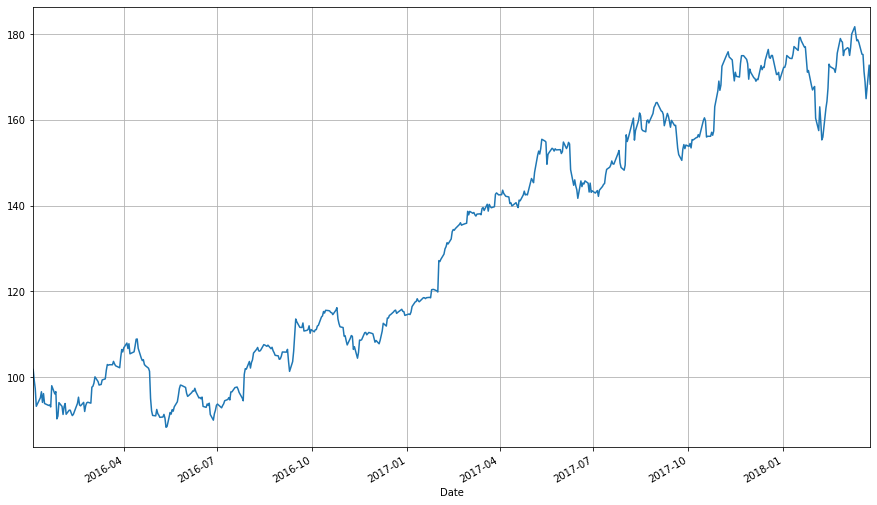

In [4]:
%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)

aapl_data["Adj. Close"].plot(grid=True)

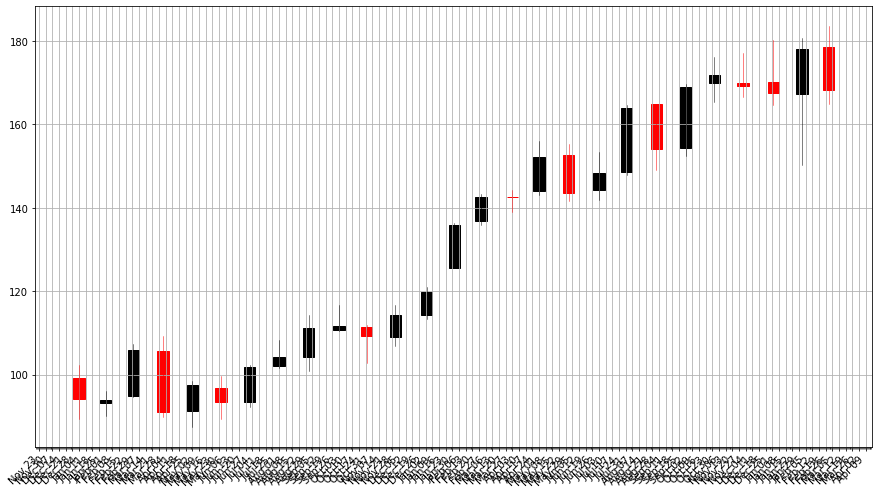

In [8]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(aapl_data, adj=True, stick="month")

In [9]:
msft_data, goog_data = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])

stocks = pd.DataFrame({"AAPL" : aapl_data['Adj. Close'],
                       "MSFT" : msft_data['Adj. Close'],
                       "GOOG" : goog_data['Adj. Close']})
stocks.head()

,AAPL,MSFT,GOOG
Date,,,
2016-01-04,101.783763,52.181598,741.84
2016-01-05,99.233131,52.419653,742.58
2016-01-06,97.291172,51.467434,743.62
2016-01-07,93.185040,49.677262,726.39
2016-01-08,93.677776,49.829617,714.47


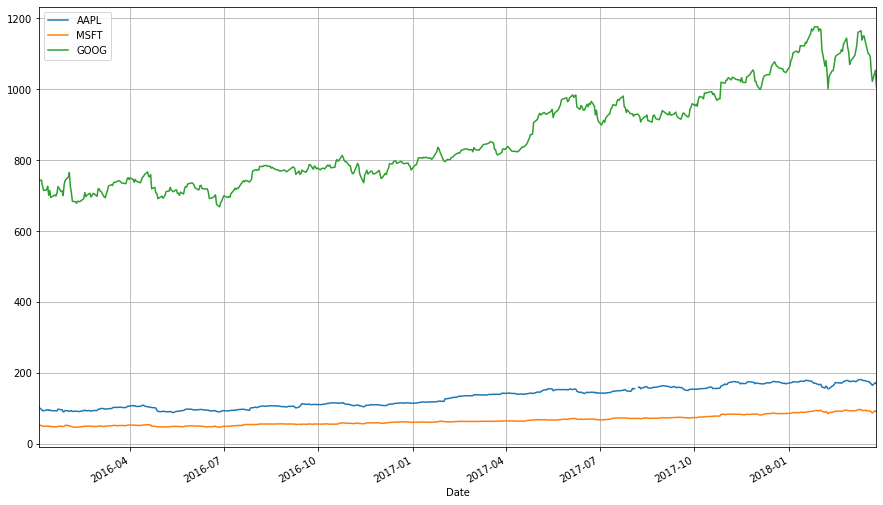

In [10]:
stocks.plot(grid=True)

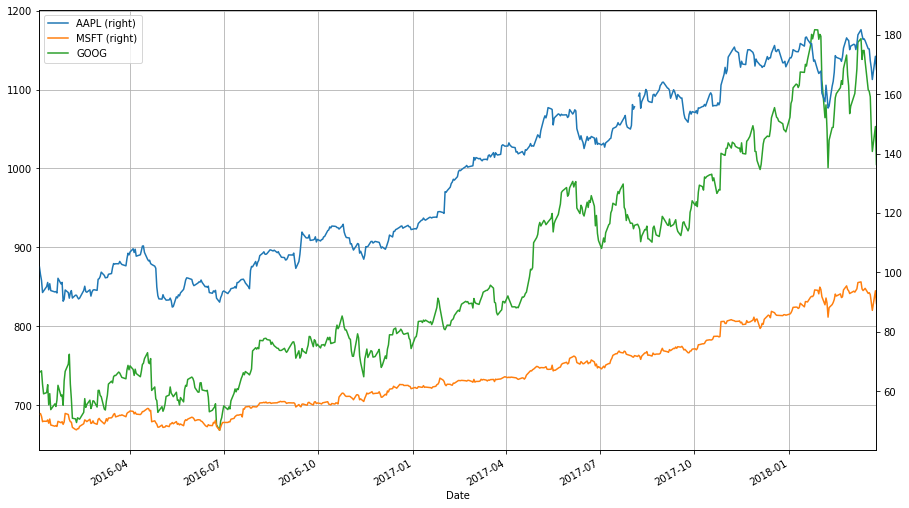

In [11]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

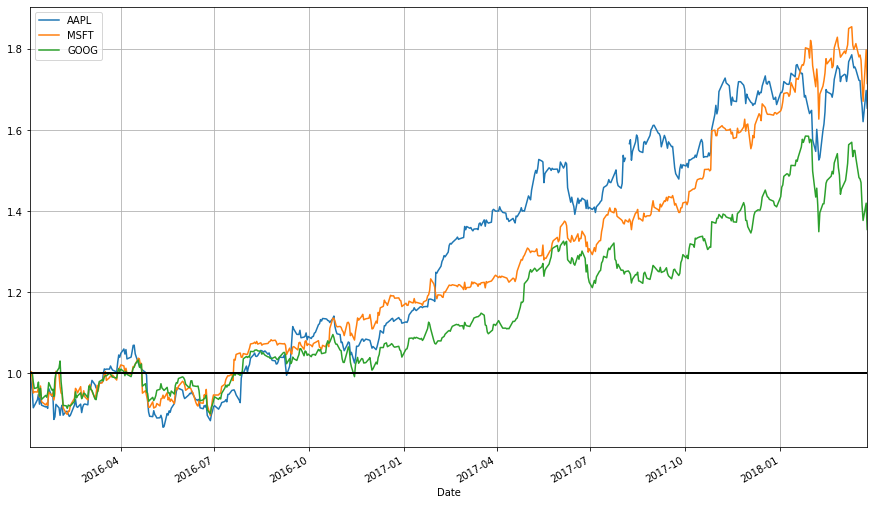

In [21]:
stock_return = stocks.apply(lambda x : x / x[0])
stock_return.plot(grid=True).axhline(y = 1, color = "black", lw = 2)

In [19]:
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,MSFT,GOOG
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.004552,0.000997
2016-01-06,-0.019764,-0.018332,0.001400
2016-01-07,-0.043121,-0.035402,-0.023443
2016-01-08,0.005274,0.003062,-0.016546


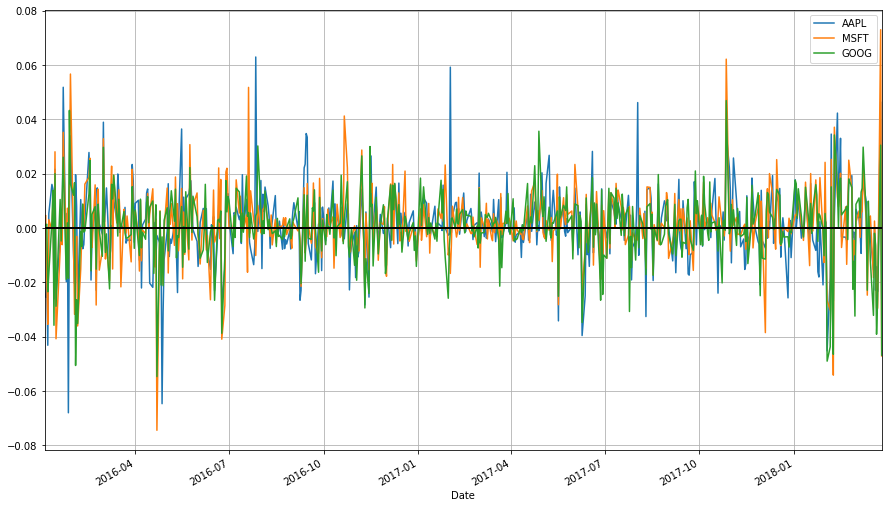

In [26]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)